In [60]:
import os
import pandas as pd
import logging 
import yaml
import matplotlib.pyplot as plt
import cv2
CONFIG_PATH = "./config.yaml"

def load_config(yaml_path: str) -> dict:
    """
    Loads configuration parameters from a YAML file into a dictionary.
    
    Args
    -----
    yaml_path : str
        Path to the YAML configuration file.
    
    Returns
    -----
    dict
        Configuration parameters loaded from YAML.
    """
    try:
        with open(yaml_path, 'r') as file:
            config = yaml.safe_load(file)
        return config
    except Exception as e:
        logging.error("Error loading config.yaml file; Are you executing the script from the root folder? If so, check this .py and change CONFIG_PATH.")

# Load the CONFIG variable
CONFIG = load_config(CONFIG_PATH)

augmentations = ["Brightness", "Contrast", "Translation", "X_ray artificial noise"]
original_path = os.path.join(CONFIG["OUTPUT_PATH"], "CADICA_Holdout_Info", "train.csv")
train_df = pd.read_csv(original_path)
augmentations_folder = os.path.join(CONFIG["OUTPUT_PATH"], "CADICA_Augmented_Images")
augmented_train_df = pd.read_csv(os.path.join(augmentations_folder, "augmented_train.csv"))

patient_video = "p34_v9"
frame_id = "00045"

In [37]:
train_df = train_df[train_df["Frame_path"].str.contains(patient_video) & train_df["Frame_path"].str.contains(frame_id)]
augmented_train_df = augmented_train_df[augmented_train_df["Frame_path"].str.contains(patient_video) & augmented_train_df["Frame_path"].str.contains(frame_id)]

In [ ]:
train_df = train_df[train_df["Frame_path"].str.contains(patient_video) & train_df["Frame_path"].str.contains(frame_id)]
augmented_train_df = augmented_train_df[augmented_train_df["Frame_path"].str.contains(patient_video) & augmented_train_df["Frame_path"].str.contains(frame_id)]

brightness = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("brightness_1")].iloc[0, :]
contrast = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("contrast_1")].iloc[0, :]
translation = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("translation_1")].iloc[0, :]
xray = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("xray_noise_1")].iloc[0, :]



,LesionLabel,Frame_path,Groundtruth_path
2323,p99,/home/mariopasc/Python/Datasets/try_coronario/...,/home/mariopasc/Python/Datasets/try_coronario/...


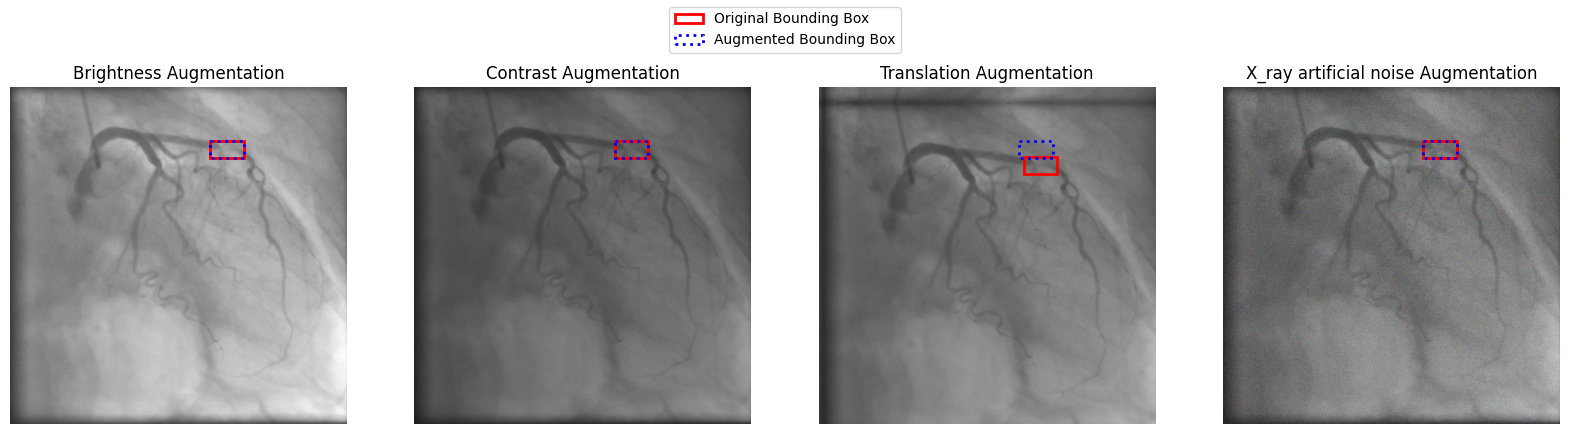

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import scienceplots  # Ensuring scienceplots is applied for consistent styling

plt.style.use(['science', 'std-colors'])

def plot_augmented_bboxes(patient_video: str, frame_id: str):
    """
    Plot a 1x4 subplot with each augmentation type for a given patient and frame.

    Parameters:
    patient_video (str): The identifier for the patient and video combination (e.g., "p34_v9").
    frame_id (str): The frame identifier (e.g., "00035").
    """
    # Set up augmentation types
    augmentations = ["Brightness", "Contrast", "Translation", "X_ray artificial noise"]
    
    # Load the filtered data for the original and augmented bounding boxes
    original_path = os.path.join(CONFIG["OUTPUT_PATH"], "CADICA_Holdout_Info", "train.csv")
    train_df = pd.read_csv(original_path)
    augmentations_folder = os.path.join(CONFIG["OUTPUT_PATH"], "CADICA_Augmented_Images")
    augmented_train_df = pd.read_csv(os.path.join(augmentations_folder, "augmented_train.csv"))

    # Filter original bounding boxes for the specified patient and frame
    train_df = train_df[train_df["Frame_path"].str.contains(patient_video) & train_df["Frame_path"].str.contains(frame_id)]
    
    # Filter augmented bounding boxes for specified augmentations
    augmented_train_df = augmented_train_df[augmented_train_df["Frame_path"].str.contains(patient_video) & augmented_train_df["Frame_path"].str.contains(frame_id)]
    
    # Identify each augmentation
    brightness = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("brightness_1")].iloc[0, :]
    contrast = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("contrast_1")].iloc[0, :]
    translation = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("translation_1")].iloc[0, :]
    xray = augmented_train_df[augmented_train_df["Groundtruth_path"].str.contains("xray_noise_1")].iloc[0, :]

    # Read the original frame image
    if not train_df.empty:
        frame_path = train_df["Frame_path"].values[0]
        original_image = cv2.imread(frame_path)
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    else:
        print("Original frame image not found for specified patient_video and frame_id.")
        return

    # Extract bounding box file paths for original and augmentations
    original_bbox_path = train_df["Groundtruth_path"].values[0]
    augmentation_data = {
        "Brightness": (brightness["Frame_path"], brightness["Groundtruth_path"]),
        "Contrast": (contrast["Frame_path"], contrast["Groundtruth_path"]),
        "Translation": (translation["Frame_path"], translation["Groundtruth_path"]),
        "X_ray artificial noise": (xray["Frame_path"], xray["Groundtruth_path"])
    }

    # Using the first two colors from std-colors
    std_colors = plt.get_cmap("tab10")
    original_bbox_color = to_rgba(std_colors(0))  # first color
    augmented_bbox_color = to_rgba(std_colors(1))  # second color

    # Create 1x4 subplot for the augmentations
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, (aug, (aug_image_path, aug_bbox_path)) in enumerate(augmentation_data.items()):
        # Load the augmented image for this augmentation
        aug_image = cv2.imread(aug_image_path)
        aug_image_rgb = cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB)
        
        # Plot the augmented image
        axes[i].imshow(aug_image_rgb)
        axes[i].set_title(f"{aug} Augmentation")
        
        # Plot original bounding boxes on augmented image
        with open(original_bbox_path, 'r') as f:
            for line in f:
                x, y, w, h, _ = line.split()
                axes[i].add_patch(plt.Rectangle((int(x), int(y)), int(w), int(h), 
                                                edgecolor=original_bbox_color, facecolor='none', lw=2, label="Original"))

        # Plot new bounding boxes for the augmentation
        with open(aug_bbox_path, 'r') as f:
            for line in f:
                x, y, w, h, _ = line.split()
                axes[i].add_patch(plt.Rectangle((int(x), int(y)), int(w), int(h), 
                                                edgecolor=augmented_bbox_color, facecolor='none', lw=2, label="Augmented"))

        # Remove axis for clarity
        axes[i].axis("off")

    # Display legend for bounding boxes in a horizontal layout
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, ["Original Bounding Box", "Augmented Bounding Box"], loc="upper center", ncol=2)

    plt.show()

# Test the function with example values
plot_augmented_bboxes("p34_v9", "00035")